<a href="https://colab.research.google.com/github/aanyasinghdhaka/AdvancingCKD_DetectionModels/blob/main/CNN_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/ct-kidney-dataset/')


In [ ]:
import tensorflow as tf

In [ ]:
import os
import cv2
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Paths
dataset_dir = '/content/drive/My Drive/ct-kidney-dataset/'
preprocessed_dir = '/content/ct_scan_preprocessed'

# Create directories for the preprocessed dataset
os.makedirs(preprocessed_dir, exist_ok=True)
train_preprocessed_dir = os.path.join(preprocessed_dir, 'train')
os.makedirs(train_preprocessed_dir, exist_ok=True)
validation_preprocessed_dir = os.path.join(preprocessed_dir, 'validation')
os.makedirs(validation_preprocessed_dir, exist_ok=True)
test_preprocessed_dir = os.path.join(preprocessed_dir, 'test')
os.makedirs(test_preprocessed_dir, exist_ok=True)

# Define categories
categories = ['Cyst', 'Normal', 'Stone', 'Tumor']

# Create subfolders in preprocessed directories
for category in categories:
    os.makedirs(os.path.join(train_preprocessed_dir, category), exist_ok=True)
    os.makedirs(os.path.join(validation_preprocessed_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_preprocessed_dir, category), exist_ok=True)

# Function to apply preprocessing and save images
def preprocess_and_save_images(category, dataset_dir, save_dir, train_ratio=0.7, validation_ratio=0.15, test_ratio=0.15):
    src_dir = os.path.join(dataset_dir, category)
    if not os.path.exists(src_dir):
        raise ValueError(f"Source directory {src_dir} does not exist")

    all_filenames = [f for f in os.listdir(src_dir) if f.endswith(('jpeg', 'jpg', 'png'))]
    if len(all_filenames) == 0:
        raise ValueError(f"No images found in directory {src_dir}")

    train_filenames, temp_filenames = train_test_split(all_filenames, test_size=1-train_ratio, random_state=42)
    validation_filenames, test_filenames = train_test_split(temp_filenames, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

    def apply_watershed(img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        kernel = np.ones((3, 3), np.uint8)
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
        sure_bg = cv2.dilate(opening, kernel, iterations=3)
        dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
        ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg, sure_fg)
        markers = cv2.connectedComponents(sure_fg)[1] + 1
        markers[unknown == 0] = 0
        markers = cv2.watershed(img, markers)
        img[markers == -1] = [255, 0, 0]
        return img

    def save_images(filenames, subset):
        for filename in filenames:
            img = cv2.imread(os.path.join(src_dir, filename))
            if img is not None:
                img_segmented = apply_watershed(img)
                cv2.imwrite(os.path.join(save_dir, subset, category, filename), img_segmented)

    save_images(train_filenames, 'train')
    save_images(validation_filenames, 'validation')
    save_images(test_filenames, 'test')

# Preprocess and save images for each category
for category in categories:
    preprocess_and_save_images(category, dataset_dir, preprocessed_dir)

# Use ImageDataGenerator's flow_from_directory method
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.05,
    rotation_range=25,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_preprocessed_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    validation_preprocessed_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_preprocessed_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 5506 images belonging to 4 classes.
Found 1181 images belonging to 4 classes.
Found 1182 images belonging to 4 classes.


In [ ]:


# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))  # Assuming 4 classes

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator
)

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy}')


Found 5506 images belonging to 4 classes.
Found 1181 images belonging to 4 classes.
Found 1182 images belonging to 4 classes.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 64)        36928

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


173/173 [==============================] - 280s 2s/step - loss: 1.1289 - accuracy: 0.5309 - val_loss: 0.8618 - val_accuracy: 0.6960
Epoch 2/50
173/173 [==============================] - 286s 2s/step - loss: 0.7490 - accuracy: 0.6976 - val_loss: 0.4964 - val_accuracy: 0.8213
Epoch 3/50
173/173 [==============================] - 277s 2s/step - loss: 0.4960 - accuracy: 0.8040 - val_loss: 0.3080 - val_accuracy: 0.8772
Epoch 4/50
173/173 [==============================] - 271s 2s/step - loss: 0.3508 - accuracy: 0.8709 - val_loss: 0.1848 - val_accuracy: 0.9221
Epoch 5/50
173/173 [==============================] - 283s 2s/step - loss: 0.2633 - accuracy: 0.9017 - val_loss: 0.1432 - val_accuracy: 0.9467
Epoch 6/50
173/173 [==============================] - 286s 2s/step - loss: 0.2123 - accuracy: 0.9281 - val_loss: 0.1089 - val_accuracy: 0.9594
Epoch 7/50
173/173 [==============================] - 291s 2s/step - loss: 0.1879 - accuracy: 0.9335 - val_loss: 0.1227 - val_accuracy: 0.9560
Epoch 8/50

In [ ]:
from sklearn.metrics import classification_report

# Generate predictions on training data
y_train_true = train_generator.classes
y_train_pred = model.predict(train_generator)
y_train_pred_classes = y_train_pred.argmax(axis=-1)

# Print classification report for training data
print("Training Classification Report:")
print(classification_report(y_train_true, y_train_pred_classes, target_names=train_generator.class_indices.keys()))


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


173/173 [==============================] - 122s 699ms/step
Training Classification Report:
              precision    recall  f1-score   support

        Cyst       0.47      0.47      0.47      2603
      Normal       0.06      0.06      0.06       342
       Stone       0.16      0.16      0.16       963
       Tumor       0.28      0.28      0.28      1598

    accuracy                           0.33      5506
   macro avg       0.24      0.24      0.24      5506
weighted avg       0.33      0.33      0.33      5506



/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


37/37 [==============================] - 21s 569ms/step - loss: 0.0559 - accuracy: 0.9915
Test accuracy: 0.9915397763252258
173/173 [==============================] - 106s 612ms/step
Training Classification Report:
              precision    recall  f1-score   support

        Cyst       0.47      0.46      0.47      2603
      Normal       0.07      0.07      0.07       342
       Stone       0.18      0.18      0.18       963
       Tumor       0.27      0.27      0.27      1598

    accuracy                           0.34      5506
   macro avg       0.25      0.25      0.25      5506
weighted avg       0.34      0.34      0.34      5506



/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


37/37 [==============================] - 18s 463ms/step
Validation Classification Report:
              precision    recall  f1-score   support

        Cyst       0.47      0.47      0.47       558
      Normal       0.01      0.01      0.01        74
       Stone       0.18      0.17      0.17       207
       Tumor       0.31      0.31      0.31       342

    accuracy                           0.34      1181
   macro avg       0.24      0.24      0.24      1181
weighted avg       0.34      0.34      0.34      1181



/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


37/37 [==============================] - 15s 392ms/step


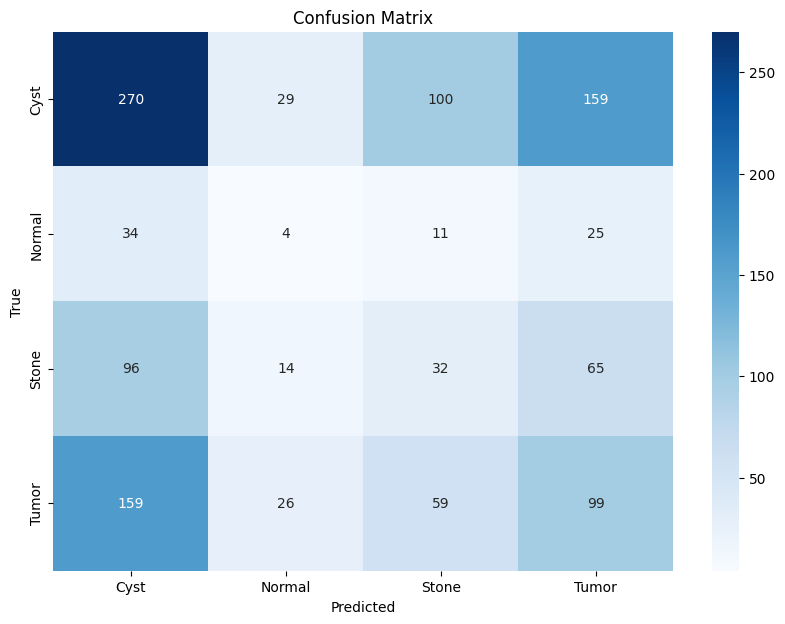

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy}')

# Generate predictions and classification reports
y_train_true = train_generator.classes
y_train_pred = model.predict(train_generator)
y_train_pred_classes = y_train_pred.argmax(axis=-1)

print("Training Classification Report:")
print(classification_report(y_train_true, y_train_pred_classes, target_names=train_generator.class_indices.keys()))

y_val_true = validation_generator.classes
y_val_pred = model.predict(validation_generator)
y_val_pred_classes = y_val_pred.argmax(axis=-1)

print("Validation Classification Report:")
print(classification_report(y_val_true, y_val_pred_classes, target_names=validation_generator.class_indices.keys()))

y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = y_pred.argmax(axis=-1)  # For multi-class classification

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the model to a file
model.save('/content/drive/My Drive/saved_model/cNNmodal')


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


37/37 [==============================] - 20s 533ms/step


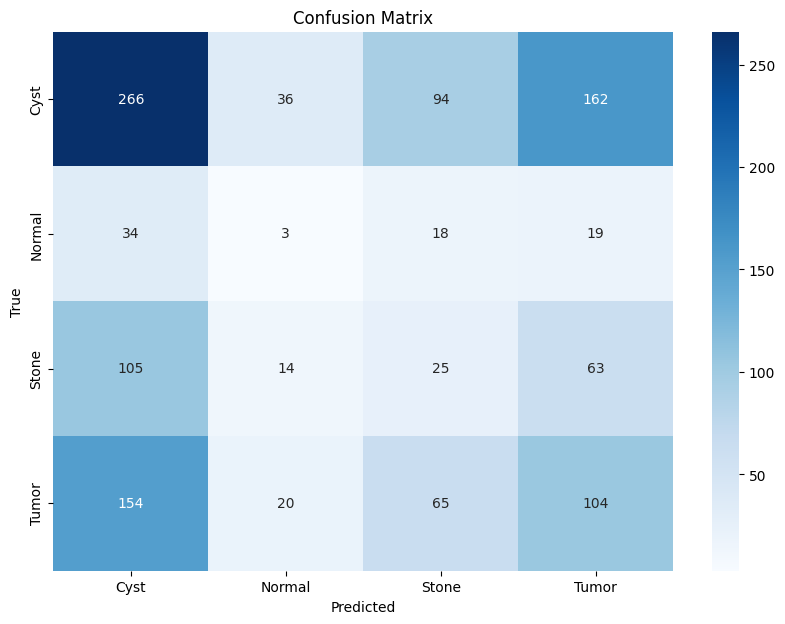

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_true are the true labels and y_pred are the predicted labels
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = y_pred.argmax(axis=-1)  # For multi-class classification

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


37/37 [==============================] - 25s 651ms/step - loss: 0.0559 - accuracy: 0.9915
Test accuracy: 0.9915397763252258


<ipython-input-26-a9033095dfb0>:12: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)


37/37 [==============================] - 15s 407ms/step


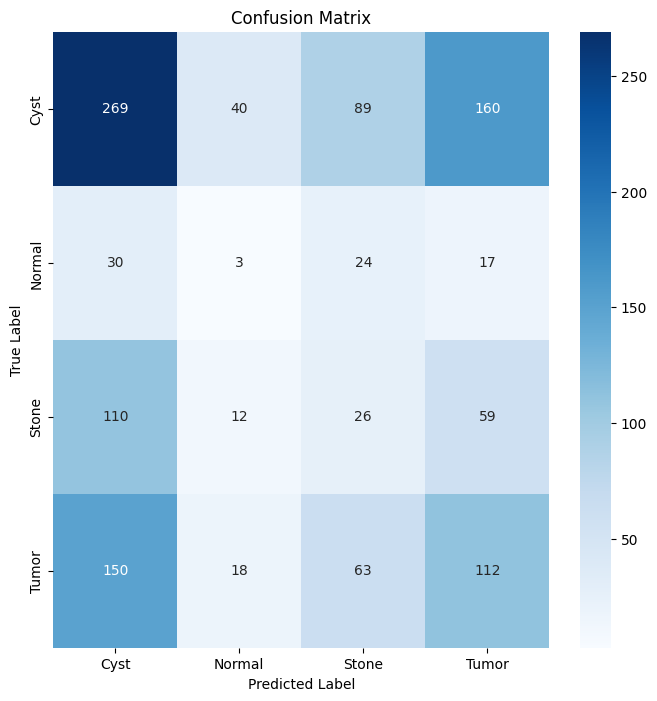

Classification Report
              precision    recall  f1-score   support

        Cyst       0.48      0.48      0.48       558
      Normal       0.04      0.04      0.04        74
       Stone       0.13      0.13      0.13       207
       Tumor       0.32      0.33      0.32       343

    accuracy                           0.35      1182
   macro avg       0.24      0.24      0.24      1182
weighted avg       0.35      0.35      0.35      1182



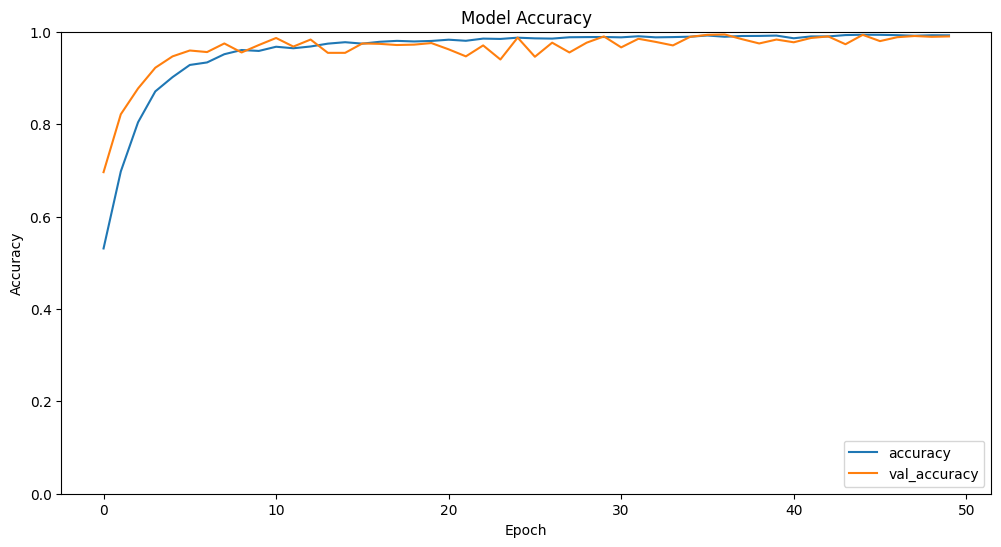

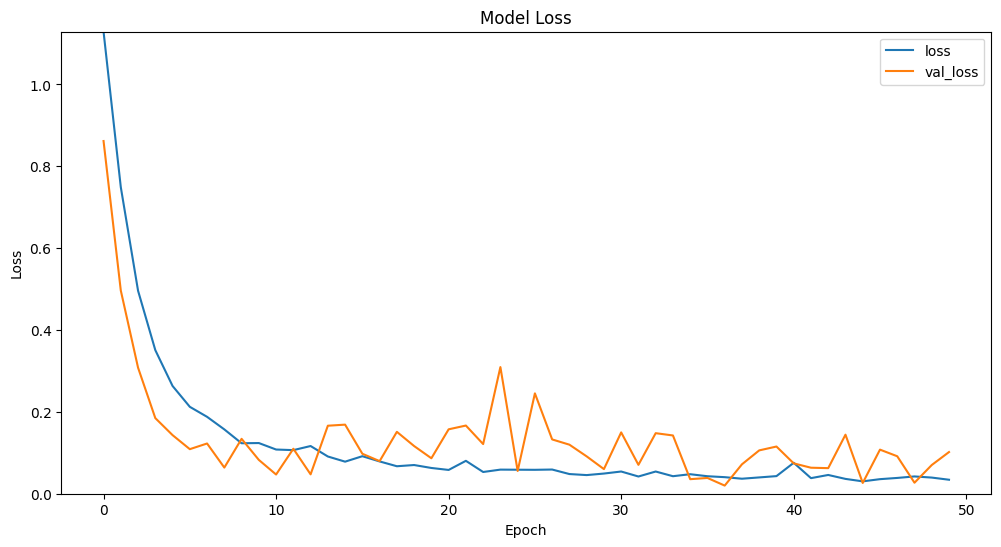

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import itertools

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy}')

# Get predictions and true labels
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print('Classification Report')
print(class_report)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, max(history.history['loss'])])
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.show()


In [ ]:
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Mount Google Drive
drive.mount('/content/drive')

# Set directory paths
dataset_dir = '/content/drive/My Drive/ct-kidney-dataset/'
preprocessed_dir = '/content/ct_scan_preprocessed'
train_preprocessed_dir = os.path.join(preprocessed_dir, 'train')
validation_preprocessed_dir = os.path.join(preprocessed_dir, 'validation')
test_preprocessed_dir = os.path.join(preprocessed_dir, 'test')

# Load the saved model
model_path = '/content/drive/My Drive/saved_model/cNNmodal'
model = load_model(model_path)

# Freeze all layers except the last few layers
for layer in model.layers[:-4]:  # Adjust the number of layers to freeze based on your model architecture
    layer.trainable = False

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Prepare image data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.05,
    rotation_range=25,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_preprocessed_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    validation_preprocessed_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_preprocessed_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# Fine-tune the model
history = model.fit(
    train_generator,
    epochs=10,  # Adjust the number of epochs based on your needs
    validation_data=validation_generator
)

# Evaluate the fine-tuned model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy}')

# Save the fine-tuned model
fine_tuned_model_path = '/content/drive/My Drive/saved_model/fine_tuned_cNNmodal'
model.save(fine_tuned_model_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 5506 images belonging to 4 classes.
Found 1181 images belonging to 4 classes.
Found 1182 images belonging to 4 classes.
Epoch 1/10
173/173 [==============================] - 121s 693ms/step - loss: 0.0376 - accuracy: 0.9935 - val_loss: 0.0883 - val_accuracy: 0.9898
Epoch 2/10
173/173 [==============================] - 117s 674ms/step - loss: 0.0245 - accuracy: 0.9947 - val_loss: 0.0756 - val_accuracy: 0.9907
Epoch 3/10
173/173 [==============================] - 109s 633ms/step - loss: 0.0263 - accuracy: 0.9935 - val_loss: 0.0654 - val_accuracy: 0.9915
Epoch 4/10
173/173 [==============================] - 112s 649ms/step - loss: 0.0255 - accuracy: 0.9947 - val_loss: 0.0609 - val_accuracy: 0.9932
Epoch 5/10
173/173 [==============================] - 105s 606ms/step - loss: 0.0158 - accuracy: 0.9949 - val_loss: 0.0584 - val_accuracy: 0.9932
Epoch 6/10
173/

In [ ]:
import numpy as np
import os
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set paths
dataset_dir = '/content/drive/My Drive/ct-kidney-dataset/'
image_size = (128, 128)
batch_size = 32
num_folds = 5  # Number of folds

# Function to create data generators
def create_generators(train_data, val_data):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.05,
        rotation_range=25,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_data,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator = val_datagen.flow_from_directory(
        val_data,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, val_generator

# List all image paths
all_image_paths = []
all_labels = []
class_names = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])
class_to_index = {cls: idx for idx, cls in enumerate(class_names)}

for class_name in class_names:
    class_dir = os.path.join(dataset_dir, class_name)
    for img_name in os.listdir(class_dir):
        all_image_paths.append(os.path.join(class_dir, img_name))
        all_labels.append(class_to_index[class_name])

all_image_paths = np.array(all_image_paths)
all_labels = np.array(all_labels)


In [ ]:
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Create KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(class_names), activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Perform K-Fold Cross-Validation
for fold, (train_index, val_index) in enumerate(kf.split(all_image_paths)):
    print(f'Fold {fold+1}/{num_folds}')

    # Split data
    train_paths, val_paths = all_image_paths[train_index], all_image_paths[val_index]
    train_labels, val_labels = all_labels[train_index], all_labels[val_index]

    # Create temporary directories for this fold
    fold_train_dir = '/content/drive/My Drive/ct-kidney-dataset/fold_train'
    fold_val_dir = '/content/drive/My Drive/ct-kidney-dataset/fold_val'
    os.makedirs(fold_train_dir, exist_ok=True)
    os.makedirs(fold_val_dir, exist_ok=True)

    # Copy files to temporary directories
    for path, label in zip(train_paths, train_labels):
        class_name = class_names[label]
        dest_dir = os.path.join(fold_train_dir, class_name)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy(path, dest_dir)

    for path, label in zip(val_paths, val_labels):
        class_name = class_names[label]
        dest_dir = os.path.join(fold_val_dir, class_name)
        os.makedirs(dest_dir, exist_ok=True)
        shutil.copy(path, dest_dir)

    # Create generators
    train_generator, val_generator = create_generators(fold_train_dir, fold_val_dir)

    # Initialize model
    model = create_model()

    # Train the model
    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=val_generator
    )

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(val_generator)
    print(f'Validation accuracy for fold {fold+1}: {val_accuracy:.4f}')

    # Save the model for each fold (optional)
    model.save(f'/content/drive/My Drive/saved_model/fold_{fold+1}_model.h5')

    # Clean up temporary directories
    shutil.rmtree(fold_train_dir)
    shutil.rmtree(fold_val_dir)


Fold 1/5
Found 6295 images belonging to 4 classes.
Found 1574 images belonging to 4 classes.
Epoch 1/10
197/197 [==============================] - 281s 1s/step - loss: 1.0082 - accuracy: 0.5716 - val_loss: 0.7813 - val_accuracy: 0.6855
Epoch 2/10
197/197 [==============================] - 264s 1s/step - loss: 0.8416 - accuracy: 0.6461 - val_loss: 0.6191 - val_accuracy: 0.7516
Epoch 3/10
197/197 [==============================] - 286s 1s/step - loss: 0.7524 - accuracy: 0.6902 - val_loss: 0.5577 - val_accuracy: 0.7675
Epoch 4/10
197/197 [==============================] - 275s 1s/step - loss: 0.6894 - accuracy: 0.7141 - val_loss: 0.5053 - val_accuracy: 0.7954
Epoch 5/10
197/197 [==============================] - 273s 1s/step - loss: 0.6258 - accuracy: 0.7536 - val_loss: 0.4397 - val_accuracy: 0.8062
Epoch 6/10
197/197 [==============================] - 265s 1s/step - loss: 0.5837 - accuracy: 0.7717 - val_loss: 0.4971 - val_accuracy: 0.7973
Epoch 7/10
197/197 [=============================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Fold 2/5
Found 6295 images belonging to 4 classes.
Found 1574 images belonging to 4 classes.
Epoch 1/10
197/197 [==============================] - 373s 1s/step - loss: 1.0026 - accuracy: 0.5801 - val_loss: 0.8425 - val_accuracy: 0.6449
Epoch 2/10
197/197 [==============================] - 275s 1s/step - loss: 0.8137 - accuracy: 0.6659 - val_loss: 0.6319 - val_accuracy: 0.7351
Epoch 3/10
197/197 [==============================] - 278s 1s/step - loss: 0.7268 - accuracy: 0.7025 - val_loss: 0.6299 - val_accuracy: 0.7351
Epoch 4/10
197/197 [==============================] - 280s 1s/step - loss: 0.6587 - accuracy: 0.7334 - val_loss: 0.5234 - val_accuracy: 0.7726
Epoch 5/10
197/197 [==============================] - 281s 1s/step - loss: 0.6181 - accuracy: 0.7481 - val_loss: 0.5143 - val_accuracy: 0.7738
Epoch 6/10
197/197 [==============================] - 274s 1s/step - loss: 0.5705 - accuracy: 0.7646 - val_loss: 0.4025 - val_accuracy: 0.8405
Epoch 7/10
197/197 [=============================

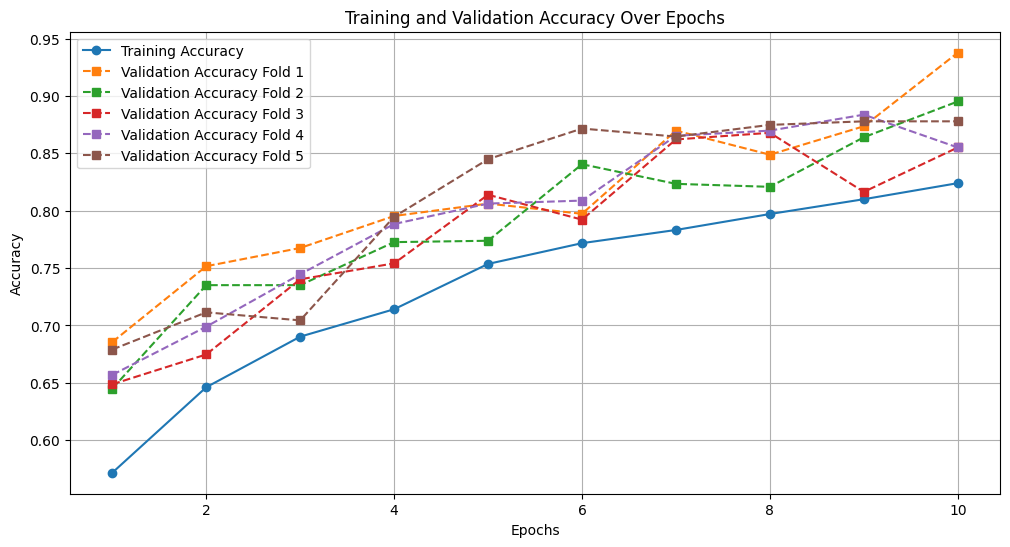

In [ ]:
import matplotlib.pyplot as plt

# Sample data
epochs = list(range(1, 11))
training_accuracies = [0.5716, 0.6461, 0.6902, 0.7141, 0.7536, 0.7717, 0.7832, 0.7971, 0.8100, 0.8240]
validation_accuracies_fold1 = [0.6855, 0.7516, 0.7675, 0.7954, 0.8062, 0.7973, 0.8698, 0.8488, 0.8736, 0.9377]
validation_accuracies_fold2 = [0.6449, 0.7351, 0.7351, 0.7726, 0.7738, 0.8405, 0.8234, 0.8208, 0.8640, 0.8952]
validation_accuracies_fold3 = [0.6487, 0.6747, 0.7402, 0.7541, 0.8139, 0.7922, 0.8621, 0.8679, 0.8164, 0.8551]
validation_accuracies_fold4 = [0.6569, 0.6989, 0.7446, 0.7884, 0.8062, 0.8088, 0.8653, 0.8698, 0.8837, 0.8551]
validation_accuracies_fold5 = [0.6790, 0.7114, 0.7044, 0.7947, 0.8449, 0.8716, 0.8646, 0.8748, 0.8779, 0.8779]

plt.figure(figsize=(12, 6))

plt.plot(epochs, training_accuracies, 'o-', label='Training Accuracy')
plt.plot(epochs, validation_accuracies_fold1, 's--', label='Validation Accuracy Fold 1')
plt.plot(epochs, validation_accuracies_fold2, 's--', label='Validation Accuracy Fold 2')
plt.plot(epochs, validation_accuracies_fold3, 's--', label='Validation Accuracy Fold 3')
plt.plot(epochs, validation_accuracies_fold4, 's--', label='Validation Accuracy Fold 4')
plt.plot(epochs, validation_accuracies_fold5, 's--', label='Validation Accuracy Fold 5')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


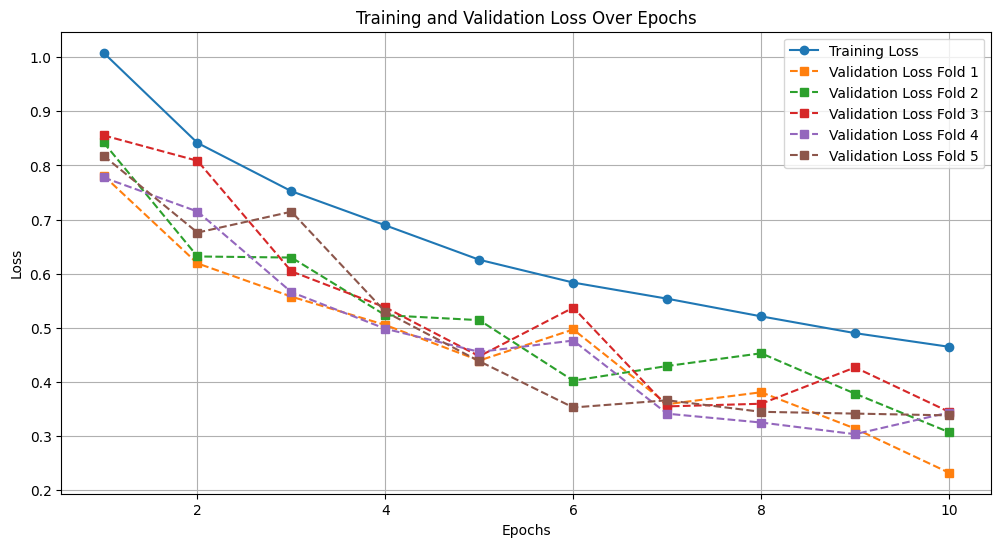

In [ ]:
# Sample data
training_losses = [1.0082, 0.8416, 0.7524, 0.6894, 0.6258, 0.5837, 0.5539, 0.5213, 0.4903, 0.4651]
validation_losses_fold1 = [0.7813, 0.6191, 0.5577, 0.5053, 0.4397, 0.4971, 0.3591, 0.3811, 0.3141, 0.2325]
validation_losses_fold2 = [0.8425, 0.6319, 0.6299, 0.5234, 0.5143, 0.4025, 0.4296, 0.4531, 0.3785, 0.3074]
validation_losses_fold3 = [0.8556, 0.8086, 0.6044, 0.5378, 0.4476, 0.5374, 0.3550, 0.3599, 0.4270, 0.3450]
validation_losses_fold4 = [0.7778, 0.7149, 0.5660, 0.4984, 0.4557, 0.4766, 0.3415, 0.3252, 0.3037, 0.3437]
validation_losses_fold5 = [0.8180, 0.6760, 0.7146, 0.5296, 0.4384, 0.3530, 0.3663, 0.3450, 0.3417, 0.3384]

plt.figure(figsize=(12, 6))

plt.plot(epochs, training_losses, 'o-', label='Training Loss')
plt.plot(epochs, validation_losses_fold1, 's--', label='Validation Loss Fold 1')
plt.plot(epochs, validation_losses_fold2, 's--', label='Validation Loss Fold 2')
plt.plot(epochs, validation_losses_fold3, 's--', label='Validation Loss Fold 3')
plt.plot(epochs, validation_losses_fold4, 's--', label='Validation Loss Fold 4')
plt.plot(epochs, validation_losses_fold5, 's--', label='Validation Loss Fold 5')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


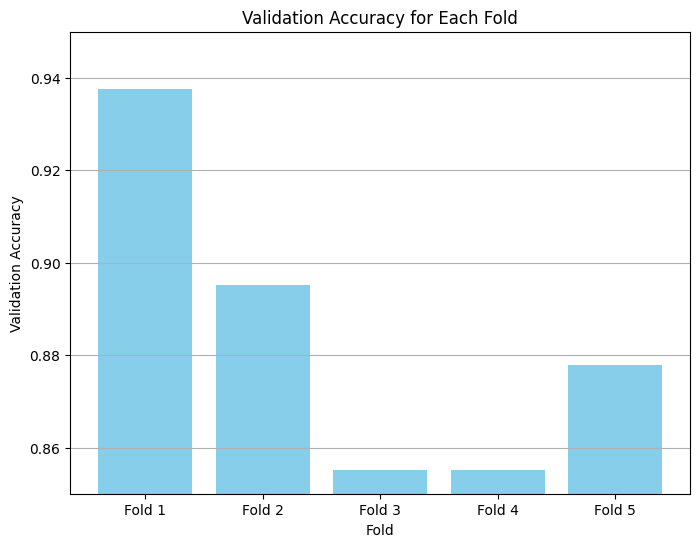

In [ ]:
import numpy as np

folds = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
accuracies = [0.9377, 0.8952, 0.8551, 0.8551, 0.8779]

plt.figure(figsize=(8, 6))

plt.bar(folds, accuracies, color='skyblue')
plt.xlabel('Fold')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Each Fold')
plt.ylim(0.85, 0.95)
plt.grid(axis='y')
plt.show()
